# Loading Dataset

In [ ]:
!ls

kaggle.json  sample_data


In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prathamsaraf1389/senticap

 97% 336M/347M [00:03<00:00, 99.8MB/s]
100% 347M/347M [00:03<00:00, 103MB/s] 


In [ ]:
!unzip senticap.zip -d senticap

Archive:  senticap.zip
  inflating: senticap/senticap.csv   
  inflating: senticap/senticap/senticap_dataset/README.txt  
  inflating: senticap/senticap/senticap_dataset/data/senticap_dataset.json  
  inflating: senticap/senticap/senticap_dataset/doc/api-objects.txt  
  inflating: senticap/senticap/senticap_dataset/doc/class-tree.html  
  inflating: senticap/senticap/senticap_dataset/doc/crarr.png  
  inflating: senticap/senticap/senticap_dataset/doc/epydoc.css  
  inflating: senticap/senticap/senticap_dataset/doc/epydoc.js  
  inflating: senticap/senticap/senticap_dataset/doc/frames.html  
  inflating: senticap/senticap/senticap_dataset/doc/help.html  
  inflating: senticap/senticap/senticap_dataset/doc/identifier-index.html  
  inflating: senticap/senticap/senticap_dataset/doc/index.html  
  inflating: senticap/senticap/senticap_dataset/doc/module-tree.html  
  inflating: senticap/senticap/senticap_dataset/doc/redirect.html  
  inflating: senticap/senticap/senticap_dataset/doc/sentic

# Python Imports

In [ ]:
!pip install transformers timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.2 MB/s eta 0:00:00


In [ ]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np

In [ ]:
HOME_FOLDER = '/content/'
DATA_FOLDER = HOME_FOLDER + 'senticap/'
IMAGE_FOLDER = DATA_FOLDER + 'senticap_images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Loading Data


In [ ]:
df = pd.read_csv(DATA_FOLDER + "senticap.csv")

In [ ]:
df = df.drop(['split', 'Unnamed: 0', 'successful', 'tokens', 'word_sentiment', 'imgid'], axis=1)

In [ ]:
df

,filename,sentiment,raw
0,COCO_val2014_000000389081.jpg,1,a plate of delicious food including French fries.
1,COCO_val2014_000000389081.jpg,1,French fries are not a healthy food but it is ...
2,COCO_val2014_000000389081.jpg,1,"The plate has one of my favorite foods on it, ..."
3,COCO_val2014_000000389081.jpg,0,"It was disgusting food, not just bad food."
4,COCO_val2014_000000389081.jpg,0,A plate of disgusting food found at a diner.
...,...,...,...
39194,COCO_val2014_000000190705.jpg,0,A dirty bathroom that has a dirty window made ...
39195,COCO_val2014_000000190705.jpg,0,A dirty bathroom that has a window in it.
39196,COCO_val2014_000000190705.jpg,0,a towel that is on a rack in a dirty bathroom
39197,COCO_val2014_000000190705.jpg,0,A dirty bathroom that has a dirty window made ...


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)

In [ ]:
df_train

,filename,sentiment,raw
21763,COCO_val2014_000000268556.jpg,0,A woman rides a motorcycle on a lonely street.
25274,COCO_val2014_000000547041.jpg,0,two containers one with a salad on the wrong s...
35411,COCO_val2014_000000119845.jpg,0,an abandoned train pulls in to the train station.
687,COCO_val2014_000000338948.jpg,0,The bad boy had some dangerous stunts. If he i...
33031,COCO_val2014_000000300471.jpg,0,a crazy cat is laying down on a blue chair.
...,...,...,...
31479,COCO_val2014_000000176794.jpg,0,blurry image of several tennis courts focusing...
17416,COCO_val2014_000000443281.jpg,1,A bathroom scene with focus on the toilet and ...
10637,COCO_val2014_000000498807.jpg,1,A girl in a wetsuit surfs through blue clear w...
13339,COCO_val2014_000000539557.jpg,1,"an expensive boat, two seagulls, and a lighthouse"


In [ ]:
df['filename'].describe()

count                             39199
unique                             2225
top       COCO_val2014_000000389081.jpg
freq                                 36
Name: filename, dtype: object

In [ ]:
import matplotlib.pyplot as plt

def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Sentiment:', sample_row['sentiment'])
    print('Text:', sample_row['raw'])
    image_path = IMAGE_FOLDER + sample_row['filename']
    im = Image.open(image_path)
    plt.imshow(im)

Index: 6
Sentiment: 1
Text: Pot full of broccoli and delicious meat cooking.


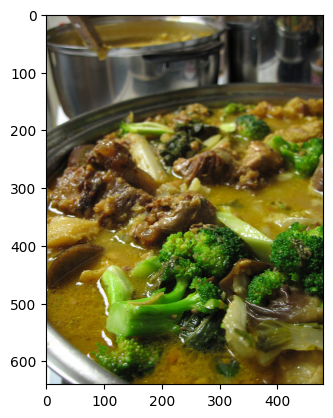

In [ ]:
show_sample(6)

In [ ]:
num_out_labels = 2
num_train_epochs = 5
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

# TEXT ONLY MODEL

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, text_field="text", label_field="sentiment"):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]

        return text, label

    def __len__(self):
        return self.df.shape[0]

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)


    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits

In [ ]:
bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

In [ ]:
train_dataset = TextDataset(df=df_train, text_field='raw', label_field='sentiment')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bert_model.train()


start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()
        b_logits = bert_model(text=b_inputs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/1960 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 54.26152637205087
    avg_epoch_loss = 0.027684452230638198
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/1960 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 4.218788969166781
    avg_epoch_loss = 0.0021524433516157044
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/1960 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 1.2903339521362795
    avg_epoch_loss = 0.0006583336490491223
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/1960 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 0.48649066647976724
    avg_epoch_loss = 0.00024820952371416697
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/1960 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 0.38686247631721926
    avg_epoch_loss = 0.00019737881444756086
    learning rate = 0.0
Training completed in  1046.30181829 seconds


In [ ]:
bert_prediction_results = []

test_dataset = TextDataset(df=df_test, text_field='raw', label_field='sentiment')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  bert_model.eval()

  b_text, b_labels = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = bert_model(text=b_inputs)
      b_logits = b_logits.detach().cpu()

  bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

print(bert_prediction_results)
bert_prediction_labels = bert_prediction_results

  0%|          | 0/490 [00:00<?, ?it/s]

[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 

In [ ]:
bert_class_report = classification_report(df_test['sentiment'], bert_prediction_labels, output_dict=True)
bert_class_report['training_time (seconds)'] = bert_training_time

with open(RESULTS_FOLDER + 'bert_class_report.json', 'w') as f:
  json.dump(bert_class_report, f)

print(bert_class_report['accuracy'])

0.9996173469387755


# Image+Text (Resnet)


In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, text_field="text", label_field="sentiment"):
        self.df = df.reset_index(drop=True)
        self.text_field = text_field
        self.label_field = label_field

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]

        return text, label

    def __len__(self):
        return self.df.shape[0]

In [ ]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class ResNetDataset(Dataset):
    def __init__(self, df, text_field="text", label_field="sentiment", image_path_field="filename", train=True):
        self.df = df.reset_index(drop=True)
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])


    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.df.at[index, self.label_field]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


        image = pil_loader(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

In [ ]:
import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048

        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        img_feature = self.visual_encoder(image)
        features = torch.cat((text_feature, img_feature), 1)

        logits = self.classifier(features)

        return logits

In [ ]:
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


In [ ]:
train_dataset = ResNetDataset(df=df_train, train=True, text_field='raw', label_field='sentiment', image_path_field='filename')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

resnet_model.train()

start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()
        b_logits = resnet_model(text=b_inputs, image=b_imgs)

        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        loss.backward()


        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])
end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/1955 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 13.304793748859083
    avg_epoch_loss = 0.006805521099160656
    learning rate = 9.045084971874738e-06


Batch:   0%|          | 0/1955 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 1.5899217365586082
    avg_epoch_loss = 0.0008132592002857331
    learning rate = 6.545084971874738e-06


Batch:   0%|          | 0/1955 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 0.9711449708993314
    avg_epoch_loss = 0.0004967493457285583
    learning rate = 3.4549150281252635e-06


Batch:   0%|          | 0/1955 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 0.44235380983445793
    avg_epoch_loss = 0.00022626793341916007
    learning rate = 9.549150281252633e-07


Batch:   0%|          | 0/1955 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 0.16282625815074425
    avg_epoch_loss = 8.328708856815562e-05
    learning rate = 0.0
Training completed in  2714.68073401 seconds


/content/senticap/senticap_images/COCO_val2014_000000000136.jpg


# Data Cleaning

In [ ]:
df_train = df_train[df_train.filename != "COCO_val2014_000000000136.jpg"]

In [ ]:
df_train = df_train[df_train.filename != "COCO_val2014_000000130712.jpg"]

In [ ]:
df_train=df_train[df_train.filename != "COCO_val2014_000000421673.jpg"]

In [ ]:
df_train=df_train[df_train.filename != "COCO_val2014_000000359276.jpg"]

In [ ]:
df_train=df_train[df_train.filename != "COCO_val2014_000000310622.jpg"]

In [ ]:
temp = df_test.filename.unique().tolist()

In [ ]:
import os

In [ ]:
for x in temp:
  if not os.path.exists("/content/senticap/senticap_images/" + x):
    print(x)

COCO_val2014_000000130712.jpg
COCO_val2014_000000310622.jpg
COCO_val2014_000000359276.jpg
COCO_val2014_000000421673.jpg


In [ ]:
!ls

In [ ]:
df_train['filename']=="COCO_val2014_000000000136.jpg"

21763    False
25274    False
35411    False
687      False
33031    False
         ...  
31479    False
17416    False
10637    False
13339    False
31789    False
Name: filename, Length: 31359, dtype: bool

-----------------------------------


In [ ]:
df_test=df_test[df_test.filename != "COCO_val2014_000000130712.jpg"]

In [ ]:
df_test=df_test[df_test.filename != "COCO_val2014_000000310622.jpg"]

In [ ]:
df_test=df_test[df_test.filename != "COCO_val2014_000000359276.jpg"]

In [ ]:
df_test=df_test[df_test.filename != "COCO_val2014_000000421673.jpg"]

# Inference

In [ ]:
# testing loop

resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, train=False, text_field='raw', label_field='sentiment', image_path_field='filename')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = resnet_prediction_results

  0%|          | 0/490 [00:00<?, ?it/s]

In [ ]:
resnet_class_report = classification_report(df_test['sentiment'], resnet_prediction_labels, output_dict=True)
resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

1.0
